In [44]:
import jax
import jax.numpy as jnp
import jax.random as jxr
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
from functools import partial
from tqdm import tqdm

import sys
sys.path.append('../')
import utils
from models import wGPLDS, WeightSpaceGaussianProcess, ParamswGPLDS

import pandas as pd
import pynapple as nap
import requests, math, os
import tqdm
import sklearn
import seaborn as sns

In [2]:
# Load data

path = "Mouse32-140822.nwb"
if path not in os.listdir("."):
    r = requests.get(f"https://osf.io/jb2gd/download", stream=True)
    block_size = 1024*1024
    with open(path, 'wb') as f:
        for data in tqdm.tqdm(r.iter_content(block_size), unit='MB', unit_scale=True,
            total=math.ceil(int(r.headers.get('content-length', 0))//block_size)):
            f.write(data)

data = nap.load_file("Mouse32-140822.nwb")

spikes = data["units"]  # Get spike timings
epochs = data["epochs"]  # Get the behavioural epochs (in this case, sleep and wakefulness)
angle = data["ry"]  # Get the tracked orientation of the animal

spikes_adn = spikes.getby_category("location")["adn"]  # Select only those units that are in ADn
adn_units = list(spikes_adn.keys())

/Users/victorgeadah_maciii/anaconda3/envs/fi_gp/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.0 because version 1.8.0 is already loaded.
  return func(args[0], **pargs)
/Users/victorgeadah_maciii/anaconda3/envs/fi_gp/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.4.0 because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
/Users/victorgeadah_maciii/anaconda3/envs/fi_gp/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.5.0 is already loaded.
  return func(args[0], **pargs)


In [3]:
# Process data

# Constants
bin_size = 0.2 # 200ms bin size
step_size = 0.05
winsize = int(bin_size / step_size)  # Window size
trial_time_length = 10
n_trials = 100

bin_edges = jnp.arange(0, trial_time_length, step_size)

all_frs = []
all_conditions = []
for i in jnp.arange(1, n_trials + 1):
  trial_start = int(9000 + i * trial_time_length)
  if trial_start > epochs['wake']['end'][0]:
    break

  # Firing rates
  peth = nap.compute_perievent(
      data=spikes_adn.restrict(epochs['wake']), 
      tref=nap.Ts(trial_start), minmax=(0, trial_time_length), time_unit='s' 
  )

  frs = []
  for u in adn_units:
    counts = peth[u].count(step_size)

    counts = (
        counts.as_dataframe()
        .rolling(winsize, win_type="gaussian", min_periods=1, center=True)
        .mean(std=winsize) # take mean of window, with std passed to Gaussian window type
    )

    fr = counts * winsize
    frs.append(fr)

  frs = jnp.array(frs).squeeze().T # (n_bins, n_units)
  all_frs.append(frs)

  # Get the conditions for trial
  angle_Tsd = nap.compute_perievent(
    angle.restrict(epochs['wake']),
    tref=nap.Ts(trial_start), minmax=(0, trial_time_length), time_unit='s'
  )[0]

  _times = angle_Tsd.times()
  _angles = angle_Tsd.as_array()

  rounded_angles = jnp.array([_angles[jnp.abs(_times - b).argmin()] for b in bin_edges])

  conditions = jnp.stack([bin_edges, rounded_angles]).T
  all_conditions.append(conditions)

all_frs = jnp.array(all_frs)
all_conditions = jnp.array(all_conditions)
print(all_frs.shape, all_conditions.shape)

/Users/victorgeadah_maciii/anaconda3/envs/fi_gp/lib/python3.10/site-packages/pynapple/core/base_class.py:42: UserWarning: Some epochs have no duration
  self.time_support = IntervalSet(start=self.index[0], end=self.index[-1])
/Users/victorgeadah_maciii/anaconda3/envs/fi_gp/lib/python3.10/site-packages/pynapple/core/base_class.py:44: RuntimeWarning: divide by zero encountered in scalar divide
  self.rate = self.index.shape[0] / np.sum(
/Users/victorgeadah_maciii/anaconda3/envs/fi_gp/lib/python3.10/site-packages/pynapple/core/base_class.py:42: UserWarning: Some epochs have no duration
  self.time_support = IntervalSet(start=self.index[0], end=self.index[-1])
/Users/victorgeadah_maciii/anaconda3/envs/fi_gp/lib/python3.10/site-packages/pynapple/core/base_class.py:44: RuntimeWarning: divide by zero encountered in scalar divide
  self.rate = self.index.shape[0] / np.sum(
/Users/victorgeadah_maciii/anaconda3/envs/fi_gp/lib/python3.10/site-packages/pynapple/core/base_class.py:42: UserWarning: 

(100, 200, 31) (100, 200, 2)


/Users/victorgeadah_maciii/anaconda3/envs/fi_gp/lib/python3.10/site-packages/pynapple/core/base_class.py:42: UserWarning: Some epochs have no duration
  self.time_support = IntervalSet(start=self.index[0], end=self.index[-1])
/Users/victorgeadah_maciii/anaconda3/envs/fi_gp/lib/python3.10/site-packages/pynapple/core/base_class.py:44: RuntimeWarning: divide by zero encountered in scalar divide
  self.rate = self.index.shape[0] / np.sum(
/Users/victorgeadah_maciii/anaconda3/envs/fi_gp/lib/python3.10/site-packages/pynapple/core/base_class.py:42: UserWarning: Some epochs have no duration
  self.time_support = IntervalSet(start=self.index[0], end=self.index[-1])
/Users/victorgeadah_maciii/anaconda3/envs/fi_gp/lib/python3.10/site-packages/pynapple/core/base_class.py:44: RuntimeWarning: divide by zero encountered in scalar divide
  self.rate = self.index.shape[0] / np.sum(
/Users/victorgeadah_maciii/anaconda3/envs/fi_gp/lib/python3.10/site-packages/pynapple/core/base_class.py:42: UserWarning: 

In [70]:
Y = all_frs
U = all_conditions[:,:,1].squeeze()

# Standardize

Y = (Y - Y.mean()) / Y.std()

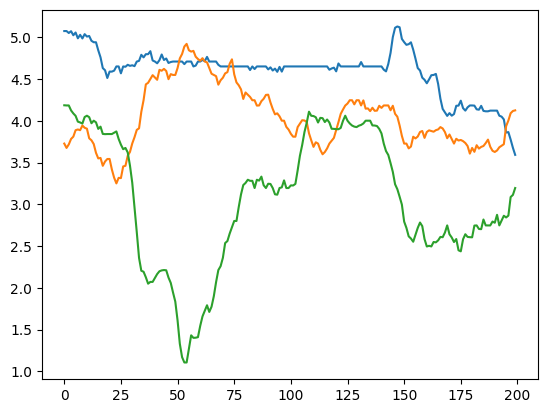

In [77]:
plt.plot(U[:3].T)

# Fit model

In [71]:
def expand_basis(basis_funcs):
    return [lambda x: f(x[0]) for f in basis_funcs]

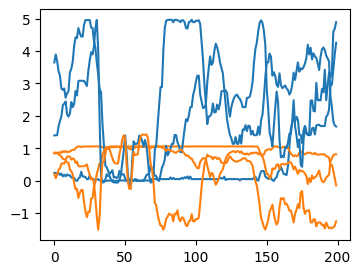

In [79]:
# Define model

latent_dim = 2
n_neurons = Y.shape[-1]

_sigma, _kappa, t_period, c_period = 1.0, 0.1, 5*trial_time_length, 2*jnp.pi
# T2_basis_funcs = utils.T2_basis(5, _sigma, _kappa, t_period, c_period)
T1_basis_funcs = utils.T1_basis(5, _sigma, _kappa, c_period)

A_prior = WeightSpaceGaussianProcess(T1_basis_funcs, D1=latent_dim, D2=latent_dim)
# b_prior = WeightSpaceGaussianProcess(torus_basis_funcs, D1=latent_dim, D2=1)
C_prior = WeightSpaceGaussianProcess(T1_basis_funcs, D1=n_neurons, D2=latent_dim)
model = wGPLDS(
    wgps={
        'A': A_prior, 
        'b': None,
        'C': C_prior,
        }, 
    state_dim=latent_dim, 
    emission_dim=n_neurons,
    )

# conditions = jnp.vstack([t_range, coherencies[7] * jnp.ones_like(t_range)])

fig, ax = plt.subplots(figsize=[4,3])
for i in range(3):
    ax.plot(A_prior.sample(jxr.PRNGKey(3), U[i])[:,0,0], c='tab:blue');
    ax.plot(A_prior.sample(jxr.PRNGKey(3), U[i])[:,0,1], c='tab:orange');

EM stopped at iteration 1 due to NaN values


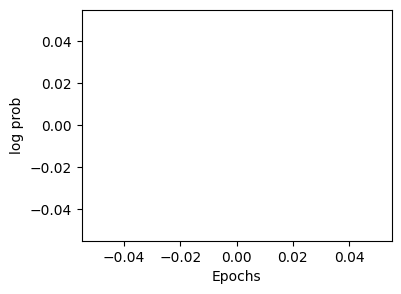

In [82]:
num_timesteps = Y.shape[1]

# Initialize
seed = 0
A_key, b_key, C_key = jxr.split(jxr.PRNGKey(seed), 3)
initial_params = ParamswGPLDS(
    dynamics_gp_weights = A_prior.weights(A_key),
    Q = 0.05 * jnp.eye(latent_dim),
    R = 0.05 * jnp.eye(n_neurons),
    m0 = jnp.zeros(latent_dim),
    S0 = jnp.eye(latent_dim),
    emissions_gp_weights = C_prior.weights(C_key),
    Cs = C_prior.sample(C_key, U[0]), #jnp.tile(jxr.normal(C_key, (n_neurons, latent_dim)), (num_timesteps, 1, 1)), #C_prior.sample(C_key, U[0]),
    bs = jnp.zeros((num_timesteps-1, latent_dim)), #b_prior.sample(b_key, conditions).squeeze(),
)

# Fit model
params, log_probs = model.fit_em(initial_params, emissions=Y, inputs=U, num_iters=200)

# Show results
fig, ax = plt.subplots(figsize=[4,3])
ax.plot(log_probs)
ax.set_ylabel('log prob')
ax.set_xlabel('Epochs');

In [8]:
# Ndim = 2 looks best, over ndim = 1 and = 5
# Tested different seeds [0,1,2,3,4], so far 0 has best marginal loglik

In [27]:
jnp.linalg.norm(Cs_theta, axis=-1).shape

(100, 31)

Text(0.5, 0.98, 'Cs')

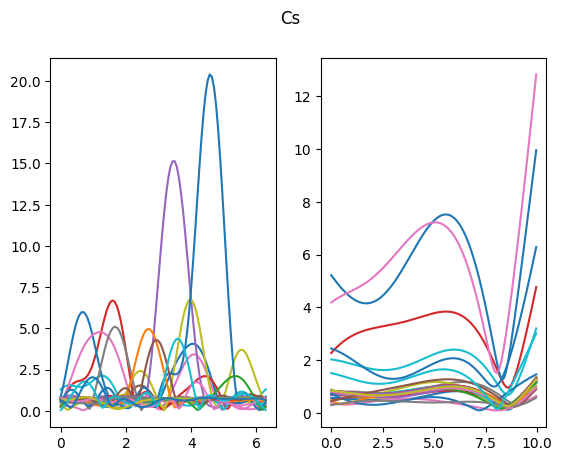

In [66]:
thetas = jnp.linspace(0, 2*jnp.pi, 100)
_theta_conditions = jnp.stack([jnp.ones_like(thetas), thetas]).T
_t_conditions = jnp.stack([bin_edges, jnp.ones(len(bin_edges))]).T
Cs_theta = C_prior(params.emissions_gp_weights, _theta_conditions)
Cs_t = C_prior(params.emissions_gp_weights, _t_conditions)

fig, axs = plt.subplots(ncols=2)
axs[0].plot(thetas, jnp.linalg.norm(Cs_theta, axis=-1));
axs[1].plot(bin_edges, jnp.linalg.norm(Cs_t, axis=-1));
fig.suptitle('Cs')

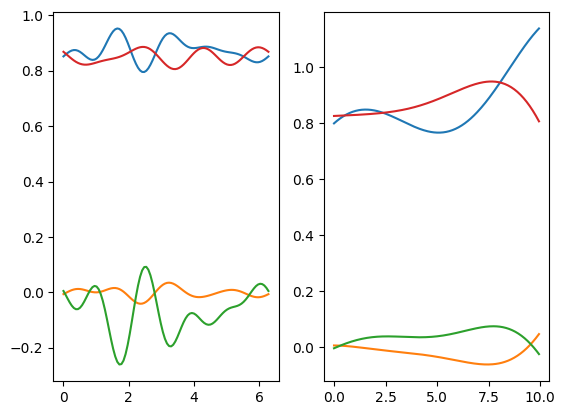

In [68]:
thetas = jnp.linspace(0, 2*jnp.pi, 100)
_theta_conditions = jnp.stack([jnp.ones_like(thetas), thetas]).T
_t_conditions = jnp.stack([bin_edges, jnp.ones(len(bin_edges))]).T
As_theta = A_prior(params.dynamics_gp_weights, _theta_conditions)
As_t = A_prior(params.dynamics_gp_weights, _t_conditions)

fig, axs = plt.subplots(ncols=2)
for i in range(latent_dim):
    for j in range(latent_dim):
        axs[0].plot(thetas, As_theta[:,i,j]);
        axs[1].plot(bin_edges, As_t[:,i,j]);

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


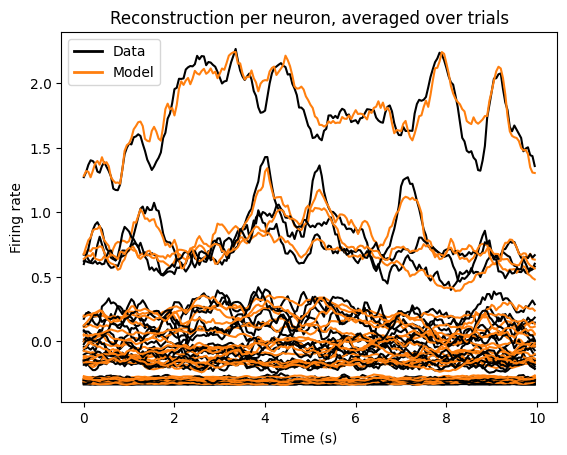

In [64]:
def reconstruct_y(b):
    _, (filtered_means, _), (smoothed_means, smoothed_covs, _) = model.smoother(params, Y[b], U[b])
    Cs = C_prior(params.emissions_gp_weights, U[b])
    _reconstructed_ys = jnp.einsum('tnl,tl->tn', Cs, smoothed_means)
    return _reconstructed_ys

reconstructed_ys = jax.vmap(reconstruct_y)(jnp.arange(len(Y)))
fig, ax = plt.subplots();
for i in range(n_neurons):
    ax.plot(bin_edges, Y.mean(0)[:,i], c='k', alpha=1.0)
    ax.plot(bin_edges, reconstructed_ys.mean(0)[:,i], c='tab:orange', alpha=1.0)
    # ax.fill_between(
    #     jnp.arange(num_timesteps), 
    #     reconstructed_ys.mean(0)[:,i] - reconstructed_ys.std(0)[:,i], 
    #     reconstructed_ys.mean(0)[:,i] + reconstructed_ys.std(0)[:,i], 
    #     color='tab:orange', alpha=0.3)

# ax.plot(Y.mean(0).mean(1), c='k', label='Data')
# ax.plot(reconstructed_ys.mean(0).mean(1), c='tab:orange', label='Model')

ax.set_ylabel('Firing rate')
ax.set_title('Reconstruction per neuron, averaged over trials')

lines = [plt.Line2D([0], [0], color='k', lw=2), plt.Line2D([0], [0], color='tab:orange', lw=2)]
ax.legend(lines, ['Data', 'Model'])
ax.set_xlabel('Time (s)');
plt.savefig(f'figures/headdirection_reconstruction.eps', format='eps')

/Users/victorgeadah_maciii/anaconda3/envs/fi_gp/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


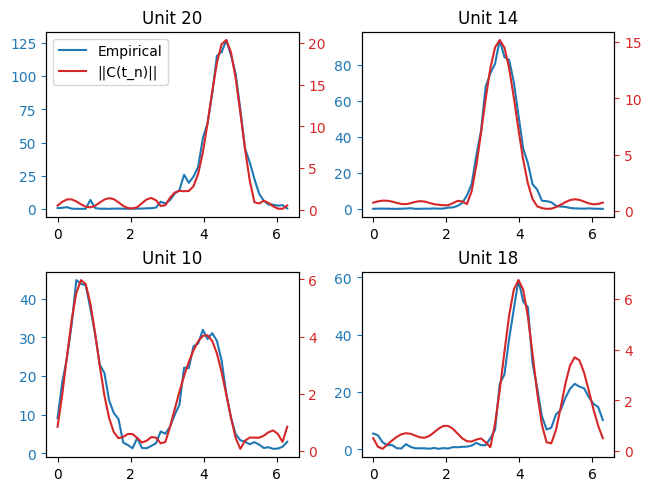

In [58]:
num_theta_bins = 50

thetas = jnp.linspace(0, 2*jnp.pi, num_theta_bins)

tuning_curves = nap.compute_1d_tuning_curves(
                    group=spikes_adn,
                    feature=angle,
                    nb_bins=num_theta_bins,
                    ep = epochs['wake'],
                    minmax=(0, 2 * jnp.pi)
                    )

tuning_curves = jnp.array([tuning_curves[u] for u in tuning_curves.keys()])
tuning_norm_sorted = jnp.argsort(jnp.linalg.norm(tuning_curves, axis=-1))[::-1]

reds = plt.get_cmap('Reds')

_U, _S, _ = jnp.linalg.svd(params.Q)
H = jnp.linalg.pinv(jnp.diag(jnp.sqrt(_S))) @ _U.T

fig, axs = plt.subplots(nrows=2, ncols=2, constrained_layout=True)
axs = axs.flatten()

for i, j in enumerate(tuning_norm_sorted[:len(axs)]):
    axs[i].plot(thetas, tuning_curves[j], c='tab:blue', label='Empirical');
    axs[i].tick_params(axis='y', colors='tab:blue')
    ax2 = axs[i].twinx()

    for t in [1]:
        _conditions = jnp.stack([t*jnp.ones_like(thetas), thetas]).T
        Cs = C_prior(params.emissions_gp_weights, _conditions)
        # Cs = jnp.einsum('tij,jn->tin', Cs, H)

        C_norm_sorted = jnp.argsort(jnp.linalg.norm(jnp.linalg.norm(Cs, axis=-1), axis=0))[::-1]
        ax2.plot(thetas, jnp.linalg.norm(Cs, axis=-1)[:,j], c='tab:red', zorder=-1, label='||C(t_n)||'); # c=reds(t/len(bin_edges[::20])),
    # Color ax
    # ax2.spines['left'].set_color('tab:blue')
    ax2.tick_params(axis='y', colors='tab:red')
    axs[i].set_title(f'Unit {j}')

# Add legend
lines = [axs[0].lines[0], ax2.lines[0]]
labels = [l.get_label() for l in lines]
axs[0].legend(lines, labels)

# for ax in axs:
#     sns.despine(ax=ax, trim=True, offset=5)

# axs[1].set_title(r'Norm of $C(\theta)$, per neuron')
# axs[0].set_title('True tuning curves')
# axs[1].set_xlabel(r'$\theta$')
# axs[0].legend()
plt.savefig('figures/tuning_curves.eps', format='eps')

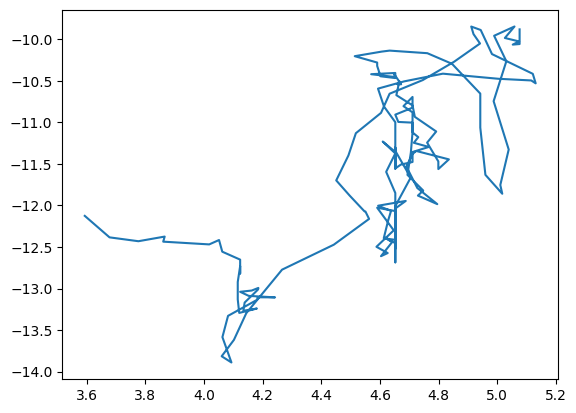

In [41]:
# smoothed_means = jax.vmap(lambda b: model.smoother(params, Y[b], U[b])[2][0])(jnp.arange(len(Y)))
# plt.plot(*smoothed_means.mean(0).T);

eigvals, eigvecs = jnp.linalg.eig(A_prior(params.dynamics_gp_weights, U[1]).mean(0))

_U, _S, _ = jnp.linalg.svd(params.Q)
H = jnp.linalg.pinv(jnp.diag(jnp.sqrt(_S))) @ _U.T

# for b in range(len(Y))[:2]:
#     x_hat = model.smoother(params, Y[b], U[b])[2][0]
#     plt.plot(*(H @ x_hat.T), '-')

x_hat = model.smoother(params, Y[0], U[0])[2][0]
plt.plot(U[0,:,1], (H @ x_hat.T)[1])

# # Plot eigenvectors
# plt.arrow(0, 0, eigvecs[0,0].real, eigvecs[0,1].real, color='r', head_width=0.1)
# plt.arrow(0, 0, eigvecs[1,0].real, eigvecs[1,1].real, color='r', head_width=0.1)

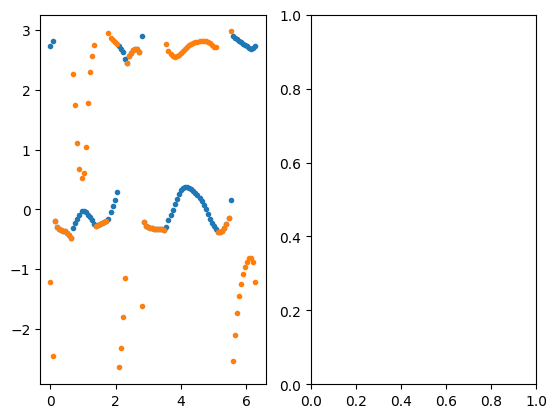

In [297]:
# plt.plot(A_prior(params.dynamics_gp_weights, U[1])[:,0]);
# plt.plot(A_prior(params.dynamics_gp_weights, U[1])[:,1]);

thetas = jnp.linspace(0, 2*jnp.pi, 100)
_theta_conditions = jnp.stack([jnp.ones_like(thetas), thetas]).T
_t_conditions = jnp.stack([bin_edges, jnp.ones(len(bin_edges))]).T
As_theta = A_prior(params.dynamics_gp_weights, _theta_conditions)
As_t = A_prior(params.dynamics_gp_weights, _t_conditions)

fig, axs = plt.subplots(ncols=2)
# axs[0].plot(thetas, As_theta[:,0]);
# axs[0].plot(thetas, As_theta[:,1]);
# axs[1].plot(bin_edges, As_t[:,0]);
# axs[1].plot(bin_edges, As_t[:,1]);
axs[0].plot(thetas, jnp.arctan2(*jnp.linalg.eig(As_theta)[1][:,:,1].T), '.');
axs[0].plot(thetas, jnp.arctan2(*jnp.linalg.eig(As_theta)[1][:,:,0].T), '.');
# axs[1].plot(bin_edges, jnp.linalg.eig(As_t)[1][:,0]);

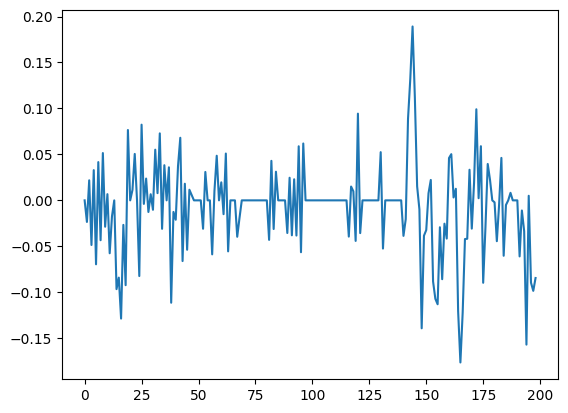

In [117]:
plt.plot(U[0,1:,1] - U[0,:-1,1])

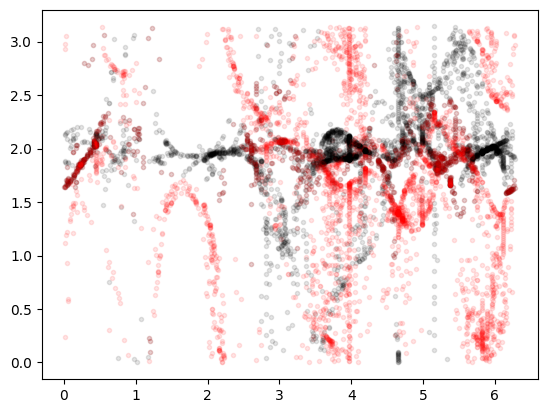

In [267]:
angles = []
for b in range(20):
    def get_angle(t):
        eigvals, eigvecs = jnp.linalg.eig(A_prior(params.dynamics_gp_weights, U[b])[t])
        sorter = jnp.argsort(eigvals.real)[::-1]
        eigvecs = eigvecs[:,sorter]
        # Calculate angle of vector
        angle_1 = jnp.arctan2(eigvecs[1,0].real, eigvecs[0,0].real)
        angle_2 = jnp.arctan2(eigvecs[1,1].real, eigvecs[0,1].real)
        return angle_1, angle_2

    angles_1, angles_2 = jax.vmap(get_angle)(jnp.arange(len(U[b])))

    angles_1 = jnp.where(angles_1 < 0, angles_1 + jnp.pi, angles_1)
    angles_2 = jnp.where(angles_2 < 0, angles_2 + jnp.pi, angles_2)
    # Make angles from [-pi, pi] to [0, 2pi]
    # angles_1 += jnp.pi
    # angles_2 += jnp.pi

    # plt.plot(-angles_1 + jnp.pi, '.')
    plt.plot(U[b,:,1], angles_1, '.', c='k', alpha=0.1)
    plt.plot(U[b,:,1], angles_2, '.', c='r', alpha=0.1)
# plt.plot(U[b,:,1], ls='--')
# plt.axhline(jnp.pi)

In [252]:
print(len(U))

100


In [167]:
jnp.arctan2(-1, -1)

Array(-2.3561945, dtype=float32, weak_type=True)

(31, 2)